# D2: Final Dataset - Data Collection, Analysis, Wrangling, Feature Engineering

Id | Category     | Value | Description 
--|:---------:|:-----------:|:-----------:
1|Name      | <i><b>Eric Gao | I'm working alone
2|Andrew ID   | <i><b>jingxia3 | My Andrew ID
3|Project Name | <i><b>Feeling Artsy | Extracting human emotions with CV techniques

## D2.1: Data Collection

**Important note: my Windows Defender reported some trojan horses in the images I downloaded. I have no idea whether they are actually trojan horses or are misclassified because of the raw binary image files before I converted them to image format. I do not guarantee the dataset is completely safe.**

**Disclaimer: The crawler is written purely for academic purposes. I do not take any responsibilities for any illegal use of the code.**

$\to$ For the data collection, I wrote following scripts:

* `image_downloader.py` - this contains the main function calls to crawl Google Images and download images to a folder using search words. All of the images are automatically reshaped to (100,100). <br>
    
* `crawler.py` - this library provide functions to emulate searching on Google Images by specific search word and gathering image urls. It uses the `selenium` library as well as `chromedriver.exe` to directly use chrome browser API to access webpages (to avoid crawler detection and make the crawling faster).<br>
    
* `downloader.py` - this library provide functions to save images using image urls. It uses the `concurrent.futures` library to perform multi-thread image downloading.<br>
    
* `postprocessing.py` - this is for combining images from different folders (with labels indicated by the folder name) into one folder, then store the file names and picture labels in a .csv file.<br>

$\to$ Here are the steps to follow if you want to run the data collection process yourself:

1. Put the aformentioned python scripts under one folder. <br>
    
1. Look for your version of `chromedriver` on `https://chromedriver.chromium.org/downloads`. After you download it (no need to install), change the `chrome_path` variable in `crawler.py` to path to your `chromedriver` if needed. <br>

1. Run the `image_downloader.py`. You will be asked to input a search keyword. For example, `cute cats`. The program will start running and will download at most 1500 images. Change the `max_number` parameter in `crawl_image_urls` function in `crawler.py` if needed. <br>

1. Repeat step 3 if needed. For this project, I repeated 4 times and each time I searched a different keyword: `paintings that show happiness or love`, `paintings that show sadness or depression`, `paintings that show fear or insecurity`, and `paintings that show anger or excitement`. <br>

1. After the previous two steps, you should have some folders of images. Rename folders if you'd like to. I renamed folders to `0`, `1`, `2`, `3` for simplicity of labelling. <br>

1. Change around parameters in the `postprocessing.py` if needed and run it. The script should generate a folder named `images` with all images in it, and an `output.csv` file that corresponds to image file names and their labels would be generated. Note that the files are first remained to `[folder name of image]img_xxx.suffix`, so conveniently the folder-names-as-labels strategy works. <br>

$\to$ Here are some additional notes:
* See the folder `crawler` for code. All of my code are explained using comments.
* See the folder `images` for dataset. The first letter in file name is the label.

## D2.2: Data Analysis

* First I need to import some basic libraries and define function for loading image

In [1]:
#import all basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.dpi']= 90

In [2]:
# define function for loading images
import os
import skimage
from skimage import io
from tqdm import tqdm
import imageio
from PIL import Image

def load_images(path='./images'):
    ids = os.listdir(path)
    images = {}
    for fname in tqdm(ids):
        product_id = fname
        img = Image.open("{}/{}".format(path, fname))
        img = np.uint8(np.asarray(img))
        if img.shape == (100,100,3):
            images[product_id] = img
    print("Loaded {} images".format(len(images)))
    return images

* After the cell below, images are stored in a dictionary: ${\{image name:pixel array\}}$

In [3]:
images = load_images() # load images

100%|██████████| 1277/1277 [00:00<00:00, 3492.87it/s]

Loaded 1248 images


In [4]:
images['0img_0001.jpeg'].shape # 100x100 pixels, 3 colors

(100, 100, 3)

* I store images in one dataframe and read from the csv which contains image names and their labels

In [5]:
imagesdf = pd.DataFrame(images.items(), columns=['ID','image'])
datadf = pd.read_csv("output.csv")

In [6]:
datadf.columns

Index(['ID', 'Label'], dtype='object')

* I combined these dataframes

In [7]:
df = pd.DataFrame(columns=['ID','image','label'])
ind = 0
for ID in images:
    df.loc[ind] = [ID, images[ID], datadf[datadf['ID']==ID]['Label'].iloc[0]]
    ind += 1

In [8]:
df.shape,df.columns

((1248, 3), Index(['ID', 'image', 'label'], dtype='object'))

* I separated the 3d pixel array to 3 columns

In [9]:
def get_red(row):
    return row['image'][:,:,0]
def get_green(row):
    return row['image'][:,:,1]
def get_blue(row):
    return row['image'][:,:,2]

df['red'] = df.apply(get_red, axis=1)
df['green'] = df.apply(get_green, axis=1)
df['blue'] = df.apply(get_blue, axis=1)

In [10]:
df['red'].shape,df['red'][4].shape

((1248,), (100, 100))

Below I look for samples from each class to do some EDA.
Note that:
* label 0: paintings that show happiness or love
* label 1: paintings that show sadness or depression
* label 2: paintings that show fear or insecurity
* label 3: paintings that show anger or excitement

In [11]:
# finding some samples of each class
samples = []

curtar = 0 # we're finding this example now
for index, row in df.iterrows():
    if row['label'] == curtar:
        samples.append(row)
        curtar += 1
    if curtar > 3: # when we found all classes
        break

In [12]:
samples[0]

ID                                          0img_0001.jpeg
image    [[[236, 236, 236], [236, 236, 236], [236, 236,...
label                                                    0
red      [[236, 236, 236, 236, 236, 236, 236, 236, 236,...
green    [[236, 236, 236, 236, 236, 236, 236, 236, 236,...
blue     [[236, 236, 236, 236, 236, 236, 236, 236, 236,...
Name: 0, dtype: object

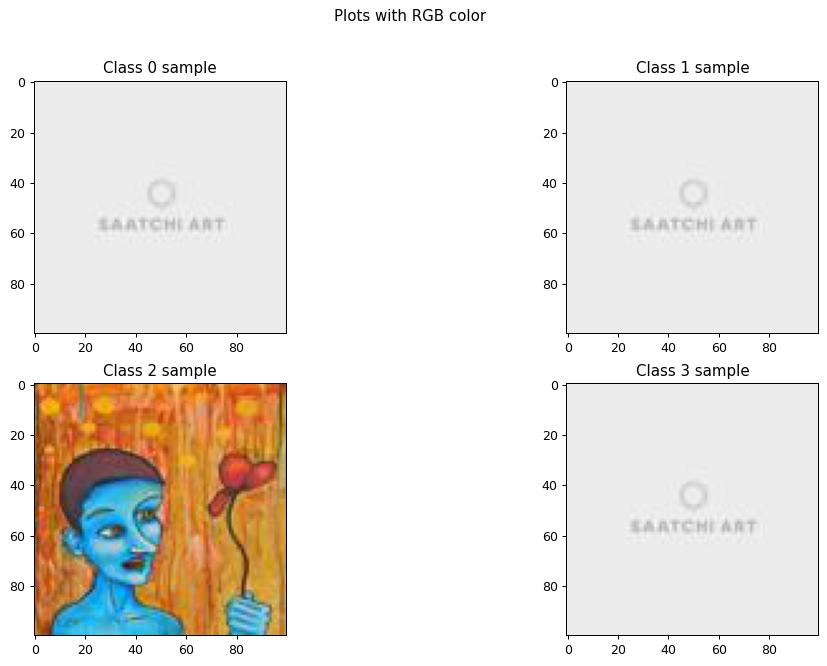

In [13]:
# RGB plots
figure, subplots = plt.subplots(2, 2, figsize=(14, 8))
figure.suptitle("Plots with RGB color")

x = 0 # x coordinate for subplot
y = 0 # y coordinate for subplot
for sample in samples:
    if y == 2: # go to next row of subplots
        x = 1
        y = 0
    subplots[x,y].imshow(np.array(sample['image']).reshape(100,100,3))
    subplots[x,y].title.set_text(f"Class {sample['label']} sample")
    y += 1
plt.show()

Class 0 sample
Red	Mean:235.26	Median:236.0	Variance:25.01
Green	Mean:235.26	Median:236.0	Variance:25.01
Blue	Mean:235.26	Median:236.0	Variance:25.01
Class 1 sample
Red	Mean:235.26	Median:236.0	Variance:25.01
Green	Mean:235.26	Median:236.0	Variance:25.01
Blue	Mean:235.26	Median:236.0	Variance:25.01
Class 2 sample
Red	Mean:165.53	Median:195.0	Variance:4401.24
Green	Mean:128.81	Median:131.0	Variance:1301.31
Blue	Mean:82.83	Median:60.0	Variance:4368.63
Class 3 sample
Red	Mean:235.26	Median:236.0	Variance:25.01
Green	Mean:235.26	Median:236.0	Variance:25.01
Blue	Mean:235.26	Median:236.0	Variance:25.01


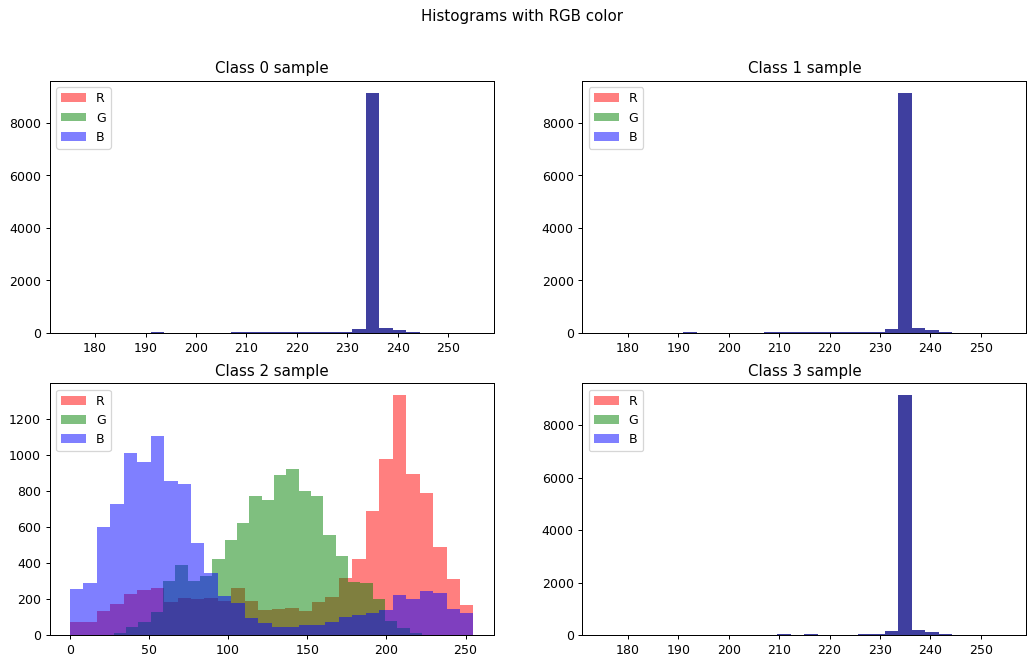

In [14]:
figure, subplots = plt.subplots(2, 2, figsize=(14, 8))
figure.suptitle("Histograms with RGB color")

x = 0 # x coordinate for subplot
y = 0 # y coordinate for subplot
for sample in samples:
    if y == 2: # go to next row of subplots
        x = 1
        y = 0
    subplots[x,y].hist(sample['red'].flatten(), bins=30, alpha=0.5, label="R", color="red")
    subplots[x,y].hist(sample['green'].flatten(), bins=30, alpha=0.5, label="G", color="green")
    subplots[x,y].hist(sample['blue'].flatten(), bins=30, alpha=0.5, label="B", color="blue")
    subplots[x,y].legend(loc='upper left')
    subplots[x,y].title.set_text(f"Class {sample['label']} sample")
    print(f"Class {sample['label']} sample")
    print(f"Red\tMean:{round(sample['red'].flatten().mean(),2)}\tMedian:{np.median(sample['red'].flatten())}\tVariance:{round(np.var(sample['red'].flatten()),2)}")
    print(f"Green\tMean:{round(sample['green'].flatten().mean(),2)}\tMedian:{np.median(sample['green'].flatten())}\tVariance:{round(np.var(sample['green'].flatten()),2)}")
    print(f"Blue\tMean:{round(sample['blue'].flatten().mean(),2)}\tMedian:{np.median(sample['blue'].flatten())}\tVariance:{round(np.var(sample['blue'].flatten()),2)}")
    y += 1

plt.show()

* As we can see, many of these pictures are invalid (meaningless) pictures because they are simply logos. We need to remove these grey-ish pictures. The way to do it is to throw away images that have very low variance.

## D2.3: Data Wrangling

* At this point, we want to remove all images that look extremely grey.

In [15]:
df['rvar'] = np.array(np.var(x.flatten()) for x in df['red'])
df['gvar'] = np.array(np.var(x.flatten()) for x in df['green'])
df['bvar'] = np.array(np.var(x.flatten()) for x in df['blue'])
df = df[df['rvar']+df['gvar']+df['bvar'] > 100]

In [16]:
df.shape,df.columns

((1013, 9),
 Index(['ID', 'image', 'label', 'red', 'green', 'blue', 'rvar', 'gvar', 'bvar'], dtype='object'))

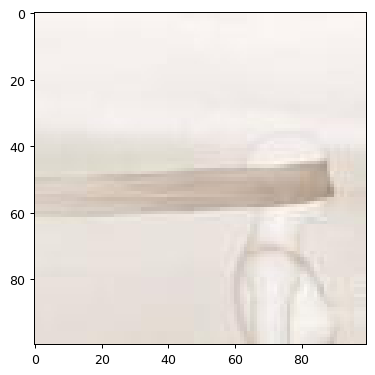

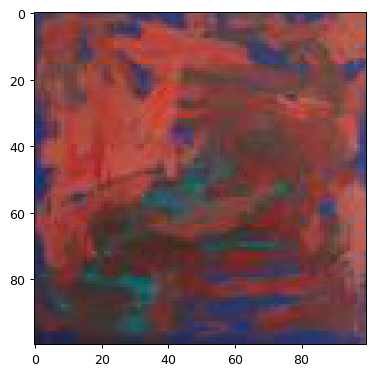

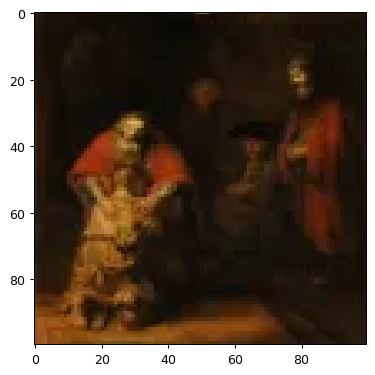

In [17]:
for i in ['rvar','gvar','bvar']:
    plt.imshow(np.array(df[df[i] == df[i].min()]['image'].values[0]).reshape(100,100,3))
    plt.show()

* We can see that even pictures with smallest variances are not logos! Our data is clean (I can't think of a way to prove this, but I think it works)!

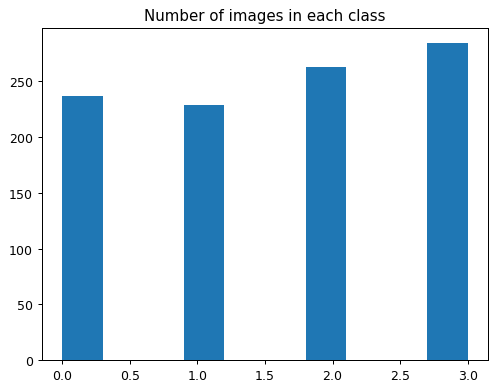

In [18]:
plt.hist(df['label'])
plt.title("Number of images in each class")
plt.show()

In [19]:
# finding some samples of each class
samples = []

curtar = 0 # we're finding this example now
for index, row in df.iterrows():
    if row['label'] == curtar:
        samples.append(row)
        curtar += 1
    if curtar > 3: # when we found all classes
        break

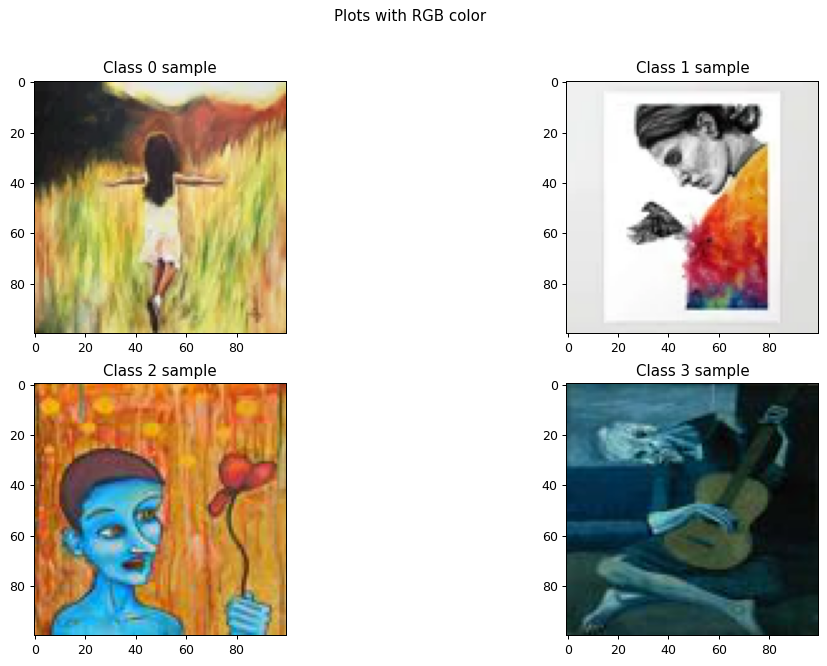

In [20]:
# RGB plots
figure, subplots = plt.subplots(2, 2, figsize=(14, 8))
figure.suptitle("Plots with RGB color")

x = 0 # x coordinate for subplot
y = 0 # y coordinate for subplot
for sample in samples:
    if y == 2: # go to next row of subplots
        x = 1
        y = 0
    subplots[x,y].imshow(np.array(sample['image']).reshape(100,100,3))
    subplots[x,y].title.set_text(f"Class {sample['label']} sample")
    y += 1
plt.show()

Class 0 sample
Red	Mean:169.04	Median:190.0	Variance:4023.43
Green	Mean:150.51	Median:171.0	Variance:3851.91
Blue	Mean:92.96	Median:89.0	Variance:1889.36
Class 1 sample
Red	Mean:209.53	Median:229.0	Variance:3565.57
Green	Mean:195.09	Median:228.0	Variance:5494.67
Blue	Mean:190.75	Median:227.0	Variance:6193.54
Class 2 sample
Red	Mean:165.53	Median:195.0	Variance:4401.24
Green	Mean:128.81	Median:131.0	Variance:1301.31
Blue	Mean:82.83	Median:60.0	Variance:4368.63
Class 3 sample
Red	Mean:31.1	Median:20.0	Variance:855.01
Green	Mean:65.23	Median:56.0	Variance:1646.95
Blue	Mean:70.93	Median:62.0	Variance:2032.73


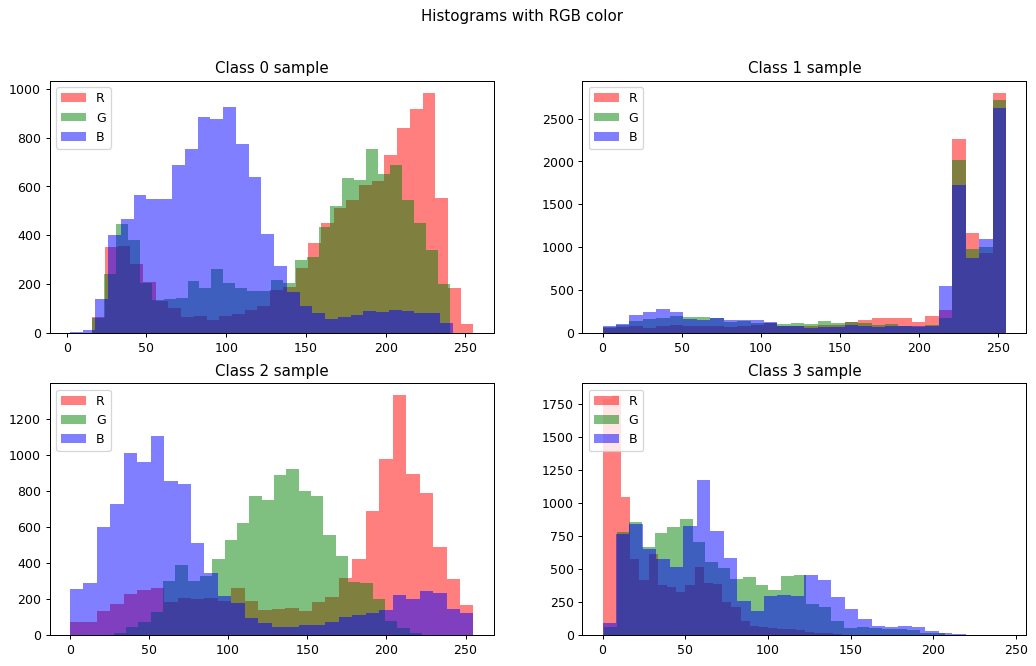

In [21]:
figure, subplots = plt.subplots(2, 2, figsize=(14, 8))
figure.suptitle("Histograms with RGB color")

x = 0 # x coordinate for subplot
y = 0 # y coordinate for subplot
for sample in samples:
    if y == 2: # go to next row of subplots
        x = 1
        y = 0
    subplots[x,y].hist(sample['red'].flatten(), bins=30, alpha=0.5, label="R", color="red")
    subplots[x,y].hist(sample['green'].flatten(), bins=30, alpha=0.5, label="G", color="green")
    subplots[x,y].hist(sample['blue'].flatten(), bins=30, alpha=0.5, label="B", color="blue")
    subplots[x,y].legend(loc='upper left')
    subplots[x,y].title.set_text(f"Class {sample['label']} sample")
    print(f"Class {sample['label']} sample")
    print(f"Red\tMean:{round(sample['red'].flatten().mean(),2)}\tMedian:{np.median(sample['red'].flatten())}\tVariance:{round(np.var(sample['red'].flatten()),2)}")
    print(f"Green\tMean:{round(sample['green'].flatten().mean(),2)}\tMedian:{np.median(sample['green'].flatten())}\tVariance:{round(np.var(sample['green'].flatten()),2)}")
    print(f"Blue\tMean:{round(sample['blue'].flatten().mean(),2)}\tMedian:{np.median(sample['blue'].flatten())}\tVariance:{round(np.var(sample['blue'].flatten()),2)}")
    y += 1

plt.show()

* Now the pictures and the color distributions make much more sense.

## D2.4: Feature Engineering

* We take the means of colors as features

In [22]:
df['rmean'] = np.array(np.mean(x.flatten()) for x in df['red'])
df['gmean'] = np.array(np.mean(x.flatten()) for x in df['green'])
df['bmean'] = np.array(np.mean(x.flatten()) for x in df['blue'])

* As well as skewness and kurtosis of colors

In [23]:
from scipy.stats import skew, kurtosis

df['rskew'] = np.array(skew(x.flatten()) for x in df['red'])
df['gskew'] = np.array(skew(x.flatten()) for x in df['green'])
df['bskew'] = np.array(skew(x.flatten()) for x in df['blue'])

df['rkurt'] = np.array(kurtosis(x.flatten()) for x in df['red'])
df['gkurt'] = np.array(kurtosis(x.flatten()) for x in df['green'])
df['bkurt'] = np.array(kurtosis(x.flatten()) for x in df['blue'])

* It would also be interesting to use a more powerful feature, HOG

In [24]:
from skimage.feature import hog
from skimage.color import rgb2gray
from skimage.transform import resize

def get_hog(img):
    grey = resize(rgb2gray(img),(100,100))
    fd, hog_image = hog(grey, orientations=8, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True)
    return hog_image

df['HOG'] = np.array(get_hog(x) for x in df['image'])

In [25]:
# finding some samples of each class
samples = []

curtar = 0 # we're finding this example now
for index, row in df.iterrows():
    if row['label'] == curtar:
        samples.append(row)
        curtar += 1
    if curtar > 3: # when we found all classes
        break

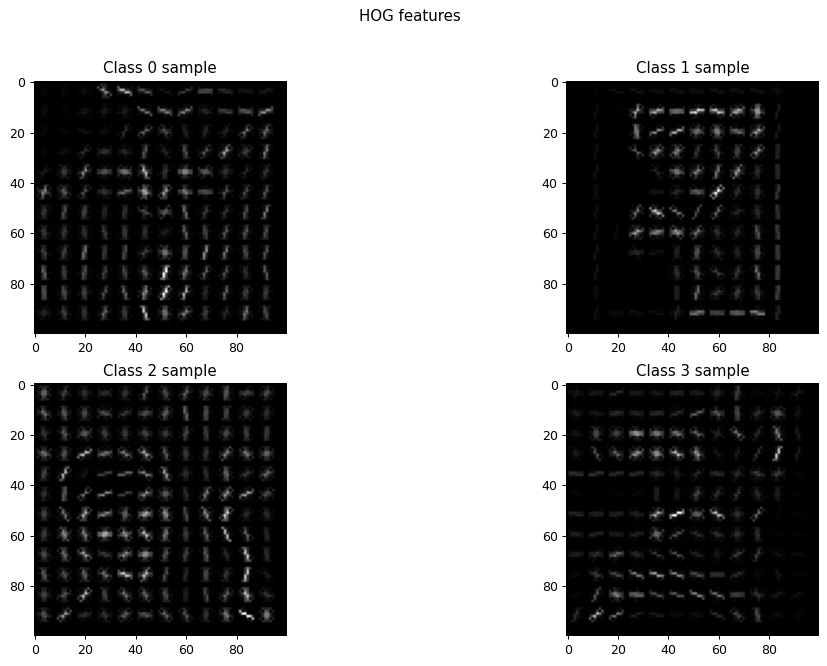

In [26]:
# RGB plots
figure, subplots = plt.subplots(2, 2, figsize=(14, 8))
figure.suptitle("HOG features")

x = 0 # x coordinate for subplot
y = 0 # y coordinate for subplot
for sample in samples:
    if y == 2: # go to next row of subplots
        x = 1
        y = 0
    subplots[x,y].imshow(np.array(sample['HOG']),cmap='gray')
    subplots[x,y].title.set_text(f"Class {sample['label']} sample")
    y += 1
plt.show()

In [27]:
df = df.reset_index()

In [28]:
df = df[['ID','image','red','green','blue','rvar','gvar','bvar','rmean','gmean','bmean','rskew','gskew','bskew','rkurt','gkurt','bkurt','HOG','label']]

In [29]:
df = df.infer_objects()

In [30]:
df.describe()

,rvar,gvar,bvar,rmean,gmean,bmean,rskew,gskew,bskew,rkurt,gkurt,bkurt,label
count,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000,1013.000000
mean,3368.936717,3013.678068,2941.163138,136.711823,125.071713,113.916717,-0.190323,-0.028922,0.142861,0.151638,0.118336,0.285492,1.586377
std,1888.467675,1711.070946,1835.503475,45.075674,45.125438,48.510828,0.979209,0.965702,1.004761,2.323918,2.178164,2.399114,1.128017
min,191.742316,183.944595,101.704088,23.411700,21.174200,11.660500,-4.356785,-4.380971,-4.266548,-1.843509,-1.834015,-1.873610,0.000000
25%,2040.998100,1764.022566,1606.170148,104.027000,93.073200,77.840400,-0.721331,-0.569515,-0.422456,-1.021006,-1.017485,-0.963695,1.000000
50%,3135.718146,2766.300920,2615.025332,138.660400,123.115000,111.062800,-0.137697,-0.006613,0.193089,-0.574199,-0.515299,-0.472196,2.000000
75%,4446.002776,3890.430628,3869.829134,168.830000,154.316900,144.435100,0.388526,0.548532,0.735279,0.382827,0.389417,0.594601,3.000000
max,11521.464239,10633.413167,10873.714339,249.009100,249.009100,249.009100,2.796933,3.061338,3.814278,28.113937,28.387360,27.165192,3.000000


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1013 entries, 0 to 1012
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1013 non-null   object 
 1   image   1013 non-null   object 
 2   red     1013 non-null   object 
 3   green   1013 non-null   object 
 4   blue    1013 non-null   object 
 5   rvar    1013 non-null   float64
 6   gvar    1013 non-null   float64
 7   bvar    1013 non-null   float64
 8   rmean   1013 non-null   float64
 9   gmean   1013 non-null   float64
 10  bmean   1013 non-null   float64
 11  rskew   1013 non-null   float64
 12  gskew   1013 non-null   float64
 13  bskew   1013 non-null   float64
 14  rkurt   1013 non-null   float64
 15  gkurt   1013 non-null   float64
 16  bkurt   1013 non-null   float64
 17  HOG     1013 non-null   object 
 18  label   1013 non-null   int64  
dtypes: float64(12), int64(1), object(6)
memory usage: 150.5+ KB


$\to$ Here we have completed the dataset `df`! However, I might come back and add more features if I find that I needed for for better training.